# NCCA Renderfarm stats

This data has been taken from the Qube logs and processed with a simple python script to csv we load the data into pandas for analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

df = pd.read_csv('outfile.csv')
# date duration durationString threads memory swap renderer
df.describe()

,duration,threads,memory,swap
count,2.246200e+04,22462.000000,2.246200e+04,2.246200e+04
mean,1.175615e+04,5.655819,3.512936e+06,8.446007e+06
std,6.200974e+04,2.274417,4.304952e+06,1.688735e+07
min,1.000000e+00,0.000000,0.000000e+00,0.000000e+00
25%,2.470000e+02,5.000000,7.752680e+05,4.542075e+06
50%,1.939000e+03,5.000000,2.505386e+06,6.072354e+06
75%,9.013000e+03,7.000000,4.263101e+06,9.277891e+06
max,1.895886e+06,15.000000,5.482115e+07,1.605482e+09


# Renderer usage by type

In [2]:
table = [["Houdini",df.renderer.str.count('houdini').sum()],
         ["Unknown",df.renderer.str.count('unknown').sum()],
         ["Arnold",df.renderer.str.count('maya arnold').sum()],
         ["Vray",df.renderer.str.count('maya vray').sum()],
        ['Renderman',df.renderer.str.count('Renderman').sum()]]
renderers=pd.DataFrame(table, columns=["Renderer", "# Renders"])
renderers=renderers.sort_values(by=['# Renders'],ascending=False)
print(renderers)


    Renderer  # Renders
0    Houdini      14949
2     Arnold       4576
3       Vray       2543
1    Unknown        389
4  Renderman          5


# Typical Render times

The following shows the typical render times per renderer, first we will define a function to process the data

In [3]:
import time
# from https://stackoverflow.com/questions/4048651/python-function-to-convert-seconds-into-minutes-hours-and-days
def secondsToText(secs):
    days = secs//86400
    hours = (secs - days*86400)//3600
    minutes = (secs - days*86400 - hours*3600)//60
    seconds = secs - days*86400 - hours*3600 - minutes*60
    result = ("{0} day{1}, ".format(days, "s" if days!=1 else "") if days else "") + \
    ("{0} hour{1}, ".format(hours, "s" if hours!=1 else "") if hours else "") + \
    ("{0} minute{1}, ".format(minutes, "s" if minutes!=1 else "") if minutes else "") + \
    ("{0} second{1}, ".format(seconds, "s" if seconds!=1 else "") if seconds else "")
    return result

def ProcessRenderStats(renderer) :
    renderDF =  df[df['renderer'].str.contains(renderer)]
    total=renderDF['duration'].sum()
    print('Total time {0}'.format(secondsToText(total)))
    print('Min duration (raw) {0} in time units {1}'.format(renderDF['duration'].min(),renderDF['durationString'][renderDF['duration'].idxmin]))
    print('Max duration (raw) {0} in time units {1}'.format(renderDF['duration'].max(),renderDF['durationString'][renderDF['duration'].idxmax]))
    print('Min memory {0}'.format(renderDF['memory'].min()))
    print('Max memory {0}'.format(renderDF['memory'].max()))
    print('Max swap {0}'.format(renderDF['swap'].max()))
    
    

## Houdini


In [4]:
ProcessRenderStats('houdini')

Total time 1672 days, 14 hours, 23 minutes, 13 seconds, 
Min duration (raw) 3 in time units 3 s
Max duration (raw) 393451 in time units 109.2 h
Min memory 0
Max memory 54821148
Max swap 59085308


# Maya Arnold

In [5]:
ProcessRenderStats('maya arnold')

Total time 1000 days, 22 hours, 14 minutes, 52 seconds, 
Min duration (raw) 7 in time units 7 s
Max duration (raw) 1895886 in time units 526.6 h
Min memory 0
Max memory 15310540
Max swap 37384156


# Maya Vray

In [6]:
ProcessRenderStats('maya vray')

Total time 355 days, 15 hours, 56 minutes, 48 seconds, 
Min duration (raw) 5 in time units 5 s
Max duration (raw) 106306 in time units 29.5 h
Min memory 0
Max memory 39406488
Max swap 1605481992


# Renderman

In [7]:
ProcessRenderStats('Renderman')

Total time 2 hours, 43 minutes, 38 seconds, 
Min duration (raw) 508 in time units 8.4 m
Max duration (raw) 4964 in time units 82.7 m
Min memory 1394080
Max memory 3179088
Max swap 10316780


# Unknown Renderer 

These files are where the log files were not written, so I can't identify what was being used, this is usually due to it being killed or a crash.

In [8]:
ProcessRenderStats('unknown')

Total time 27 days, 31 minutes, 51 seconds, 
Min duration (raw) 1 in time units 1 s
Max duration (raw) 58174 in time units 16.1 h
Min memory 0
Max memory 1826740
Max swap 9072896


# Load by Month

This data is from Jan 2019 onwards

## Total Rendertime

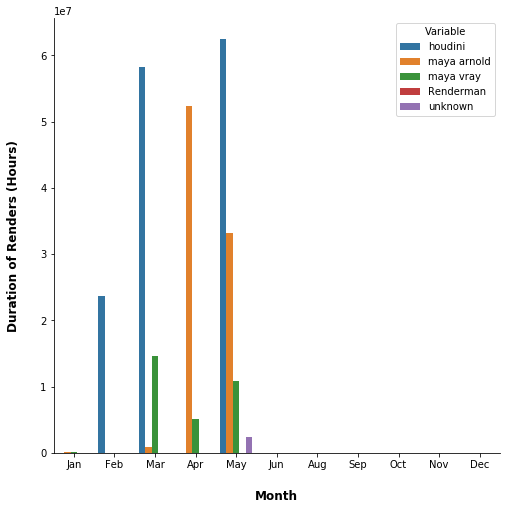

     houdini  maya arnold  maya vray  Renderman  unknown Month
0          0       124417     175039        912       85   Jan
1   23665661            0      15769          0      526   Feb
2   58306616       911084   14622899       8906     3163   Mar
3       1611     52314575    5044419          0      203   Apr
4   62538705     33130016   10871282          0  2330734   May
5          0            0          0          0        0   Jun
6          0            0          0          0        0   Aug
7          0            0          0          0        0   Sep
8          0            0          0          0        0   Oct
9          0            0          0          0        0   Nov
10         0            0          0          0        0   Dec


In [9]:
import seaborn as sns

months=['Jan','Feb','Mar','Apr','May','Jun','Aug','Sep','Oct', 'Nov' ,'Dec']
rend=['houdini','maya arnold','maya vray','Renderman','unknown']
year={}

for m in months :
    year[m]=df[df['date'].str.contains(m)]
data={    
      r :  list(map(lambda m : 
                    year[m][year[m]['renderer'].str.contains(r)]['duration'].sum() , 
                    months )) 
      for r in rend  
}
data['Month']= months

df = pd.DataFrame(data=data)

fig, ax = plt.subplots(figsize=(8, 8))
tidy = df.melt(id_vars='Month').rename(columns=str.title)
sns.barplot(x='Month', y='Value', hue='Variable', data=tidy, ax=ax)
ax.set_ylabel("Duration of Renders (Hours)", labelpad=20, weight='bold', size=12)
ax.set_xlabel("Month", labelpad=20, weight='bold', size=12)
plt.ticklabel_format(style='sci', axis='y')


sns.despine(fig)
plt.show()

print(df)

